<a href="https://colab.research.google.com/github/melkatewabe10/Machine-learning_LST-Estimation-/blob/main/prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rasterio
!pip install joblib
!pip install scikit-learn
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 39.0 MB/s eta 0:00:00


# Import library

In [ ]:
import os
import joblib
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from collections import OrderedDict

# =============================================================================
# Load the Saved Random Forest Model
# =============================================================================
model_path = "/content/drive/MyDrive/MASK_TAIN/2024_DEMO/rfm3_model.pkl"  # Update if needed
rf_model = joblib.load(model_path)
print("Model loaded successfully from:", model_path)


Model loaded successfully from: /content/drive/MyDrive/MASK_TAIN/2024_DEMO/rfm3_model.pkl


# Tsm_Prediction

In [ ]:
# =============================================================================
# Define New Data Folder and File Paths
# =============================================================================
print("Loading new predictor data for LST prediction...")

tsm_data_folder = '/content/drive/MyDrive/Taiwan_Yearly /Taiwan_2023'  # Fixed folder path

# Define predictor file paths
tsm_predictor_files = OrderedDict({
    'elv':   os.path.join(tsm_data_folder, 'ELV_2023.tif'),
    'slope': os.path.join(tsm_data_folder, 'SLP_2023.tif'),
    'ndvi':  os.path.join(tsm_data_folder, 'NDVI_2023.tif'),
    'evi':   os.path.join(tsm_data_folder, 'EVI_2023.tif'),
    'ndwi':  os.path.join(tsm_data_folder, 'NDWI_2023.tif'),
    'lai':   os.path.join(tsm_data_folder, 'LAI_2023.tif'),
    'alb':   os.path.join(tsm_data_folder, 'ALB_2023.tif'),
    'dsr':   os.path.join(tsm_data_folder, 'DSR_2023.tif')
})

# # LST file (for masking invalid pixels)
# lst_file_path = os.path.join(new_data_folder, 'LST_2023.tif')  # Provide the correct LST file

# =============================================================================
# Load New Predictor Data
# =============================================================================
tsm_predictors = {}
meta = None  # Store metadata for saving output

for key, file_path in tsm_predictor_files.items():
    with rasterio.open(file_path) as src:
        tsm_predictors[key] = src.read(1)  # Read as a 2D NumPy array
        if meta is None:
            meta = src.meta  # Save metadata from the first file

# Ensure all rasters have the same shape
raster_shape = next(iter(tsm_predictors.values())).shape

# # Load the LST data for masking invalid pixels
# with rasterio.open(lst_file_path) as src:
#     lst_data = src.read(1)  # Read LST as a 2D array

# =============================================================================
# Stack tsm Predictors for Model Input
# =============================================================================
print("Preparing data for LST prediction...")

# Flatten each raster and stack into a 2D feature matrix (rows: pixels, cols: features)
tsm_feature_list = [tsm_predictors[key].flatten() for key in tsm_predictor_files.keys()]
tsm_features = np.vstack(tsm_feature_list).T  # Convert to (num_pixels, num_features)

# =============================================================================
# Predict LST Using the Trained Model
# =============================================================================
print("Predicting LST values...")
tsm_predicted_lst = rf_model.predict(tsm_features)

# Reshape 1D predictions back into 2D raster format
tsm_predicted_lst_image = tsm_predicted_lst.reshape(raster_shape)

# Mask Invalid Pixels Using LST Data
# =============================================================================
print("Applying mask based on LST data...")

# tsm_predicted_lst_image[~np.isfinite(tsm_predicted_lst['elv'])] = np.nan
tsm_predicted_lst_image[~np.isfinite(tsm_predictors['elv'])] = np.nan #
# =============================================================================
# Save Predicted LST as a GeoTIFF File
# =============================================================================
tsm_output_path = os.path.join(tsm_data_folder, 'tsm2_Predicted_LST_2023.tif')

# Update metadata for saving (set dtype to float32)
meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)

with rasterio.open(tsm_output_path, 'w', **meta) as dst:
    dst.write(tsm_predicted_lst_image.astype(rasterio.float32), 1)

print("tsm predicted LST image saved to:", tsm_output_path )



Loading new predictor data for LST prediction...
Preparing data for LST prediction...
Predicting LST values...
Applying mask based on LST data...
tsm predicted LST image saved to: /content/drive/MyDrive/Taiwan_Yearly /Taiwan_2023/tsm2_Predicted_LST_2023.tif


# Tsm_plot

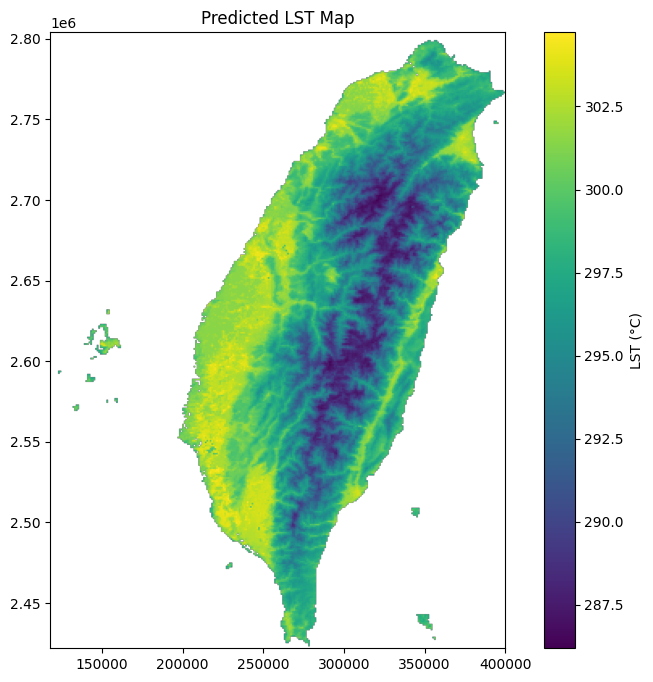

In [ ]:
plt.figure(figsize=(10, 8))
# Instead of directly passing 'transform', use 'extent' derived from the transform:
extent = [
    meta['transform'][2],
    meta['transform'][2] + meta['transform'][0] * meta['width'],
    meta['transform'][5] + meta['transform'][4] * meta['height'],
    meta['transform'][5],
]
im = plt.imshow(tsm_predicted_lst_image, extent=extent, cmap='viridis')
plt.title("Predicted LST Map")
plt.colorbar(im, label="LST (°C)")  # Pass the mappable object (im) to colorbar
plt.show()

# Correlation of Tsm vs. Tso

In [ ]:
# Load the original LST data
original_lst_file = os.path.join(tsm_data_folder, 'LST_2023.tif')  # Update with the correct path
with rasterio.open(original_lst_file) as src:
    original_lst_data = src.read(1)
    original_meta = src.meta

# Flatten the arrays to 1D for R2, RMSE, and MAE calculation
original_lst_flat = original_lst_data.flatten()
predicted_lst_flat = tsm_predicted_lst_image.flatten()

# Remove NaN values from both arrays before calculating the metrics
mask = ~np.isnan(original_lst_flat) & ~np.isnan(predicted_lst_flat)
original_lst_flat = original_lst_flat[mask]
predicted_lst_flat = predicted_lst_flat[mask]

# Calculate R² (R-squared)
r_squared = r2_score(original_lst_flat, predicted_lst_flat)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(original_lst_flat, predicted_lst_flat)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(original_lst_flat, predicted_lst_flat)

# Print results
print(f"R-squared (R²): {r_squared:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

R-squared (R²): 0.9635
Mean Squared Error (MSE): 0.7694
Root Mean Squared Error (RMSE): 0.8772
Mean Absolute Error (MAE): 0.6620


# Tn_preidiction

In [ ]:
# =============================================================================
# Define New Data Folder and File Paths
# =============================================================================
print("Loading new predictor data for LST prediction...")

tn_data_folder = '/content/drive/MyDrive/Taiwan_Yearly /Taiwan_2023'  # Fixed folder path
# Define predictor file paths
tn_predictor_files = OrderedDict({
    'elv':   os.path.join(tn_data_folder, 'ELVref_2023.tif'),
    'slope': os.path.join(tn_data_folder, 'SLPref__2023.tif'),
    'ndvi':  os.path.join(tn_data_folder, 'NDVI_2023.tif'),
    'evi':   os.path.join(tn_data_folder, 'EVI_2023.tif'),
    'ndwi':  os.path.join(tn_data_folder, 'NDWI_2023.tif'),
    'lai':   os.path.join(tn_data_folder, 'LAI_2023.tif'),
    'alb':   os.path.join(tn_data_folder, 'ALB_2023.tif'),
    'dsr':   os.path.join(tn_data_folder, 'DSRref_2023.tif')
})

# # LST file (for masking invalid pixels)
# lst_file_path = os.path.join(tn_data_folder, 'LST_2024.tif')  # Provide the correct LST file

# =============================================================================
# Load tn Predictor Data
# =============================================================================
tn_predictors = {}
meta = None  # Store metadata for saving output

for key, file_path in tn_predictor_files.items():
    with rasterio.open(file_path) as src:
        tn_predictors[key] = src.read(1)  # Read as a 2D NumPy array
        if meta is None:
            meta = src.meta  # Save metadata from the first file

# Ensure all rasters have the same shape
raster_shape = next(iter(tn_predictors.values())).shape

# # Load the LST data for masking invalid pixels
# with rasterio.open(lst_file_path) as src:
#     lst_data = src.read(1)  # Read LST as a 2D array

# =============================================================================
# Stack tn Predictors for Model Input
# =============================================================================
print("Preparing data for LST prediction...")

# Flatten each raster and stack into a 2D feature matrix (rows: pixels, cols: features)
tn_feature_list = [tn_predictors[key].flatten() for key in tn_predictor_files.keys()]
tn_features = np.vstack(tn_feature_list).T  # Convert to (num_pixels, num_features)

# =============================================================================
# Predict LST Using the Trained Model
# =============================================================================
print("Predicting LST values...")
tn_predicted_lst = rf_model.predict(tn_features)

# Reshape 1D predictions back into 2D raster format
tn_predicted_lst_image = tn_predicted_lst.reshape(raster_shape)

# Mask Invalid Pixels Using LST Data
# =============================================================================
print("Applying mask based on LST data...")
# tn_predicted_lst_image[~np.isfinite(tn_predicted_lst['elv'])] = np.nan
tn_predicted_lst_image[~np.isfinite(tn_predictors['ndvi'])] = np.nan #
# =============================================================================
# Save Predicted LST as a GeoTIFF File
# =============================================================================
tn_output_path = os.path.join(tn_data_folder, 'tn2_Predicted_LST_2024.tif')

# Update metadata for saving (set dtype to float32)
meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)

with rasterio.open(tn_output_path, 'w', **meta) as dst:
    dst.write(tn_predicted_lst_image.astype(rasterio.float32), 1)

print("tn predicted LST image saved to:", tn_output_path)

Loading new predictor data for LST prediction...
Preparing data for LST prediction...
Predicting LST values...
Applying mask based on LST data...
tn predicted LST image saved to: /content/drive/MyDrive/Taiwan_Yearly /Taiwan_2023/tn2_Predicted_LST_2024.tif


#Tn plot

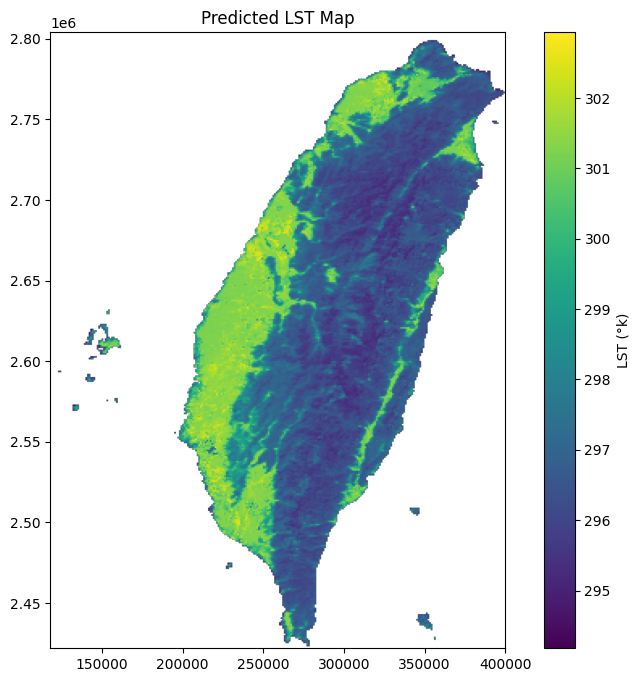

In [ ]:
plt.figure(figsize=(10, 8))
# Instead of directly passing 'transform', use 'extent' derived from the transform:
extent = [
    meta['transform'][2],
    meta['transform'][2] + meta['transform'][0] * meta['width'],
    meta['transform'][5] + meta['transform'][4] * meta['height'],
    meta['transform'][5],
]
im = plt.imshow(tn_predicted_lst_image, extent=extent, cmap='viridis')
plt.title("Predicted LST Map")
plt.colorbar(im, label="LST (°k)")  # Pass the mappable object (im) to colorbar
plt.show()

# Tn_histogram

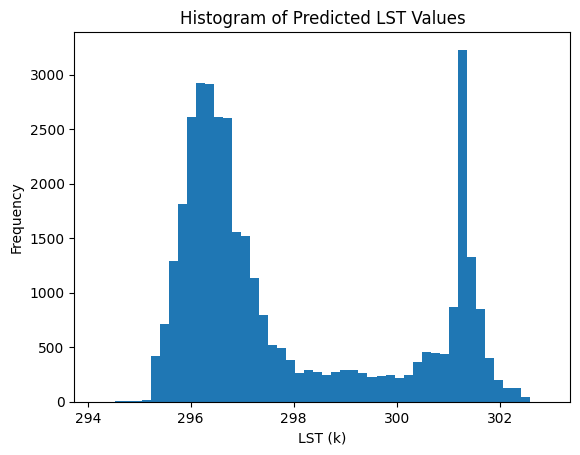

In [ ]:
# prompt: hist

import matplotlib.pyplot as plt

plt.hist(tn_predicted_lst_image.flatten(), bins=50)  # Adjust bins as needed
plt.xlabel("LST (k)")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted LST Values")
plt.show()


# Tso-Tsm >>> e

In [ ]:
# Check for matching shapes
if original_lst_data.shape != tsm_predicted_lst_image.shape:
    raise ValueError("Original and predicted LST data shapes do not match.")

# Subtract tsm_predicted_lst from original lst_data, handling NaN values gracefully
diff_tsm = np.where(np.isfinite(original_lst_data) & np.isfinite(tsm_predicted_lst_image),
                    original_lst_data - tsm_predicted_lst_image,
                    np.nan)

# Save the difference LST as a GeoTIFF file
diff_output_path = os.path.join(tsm_data_folder, 'Difference_LST_2024.tif')
original_meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)

with rasterio.open(diff_output_path, 'w', **original_meta) as dst:
    dst.write(diff_tsm.astype(rasterio.float32), 1)

print("Difference LST image saved to:", diff_output_path)


Difference LST image saved to: /content/drive/MyDrive/Taiwan_Yearly /Taiwan_2023/Difference_LST_2024.tif


# Display "e"

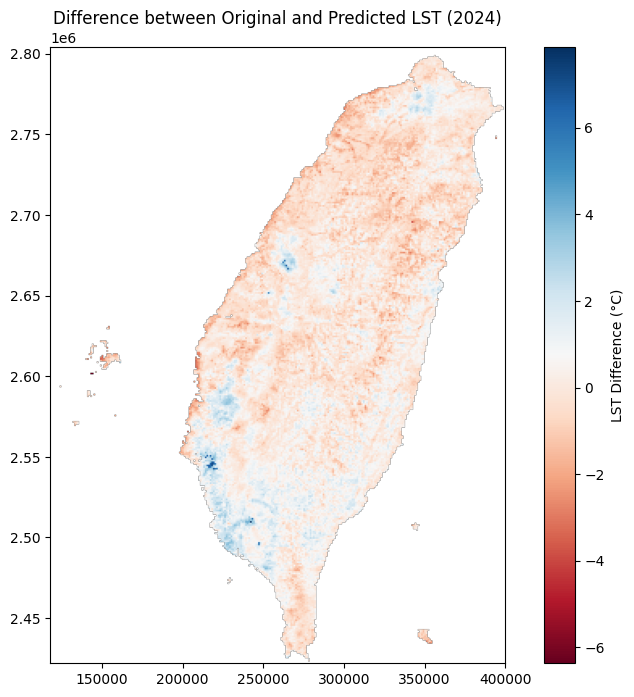

In [ ]:
# Display the difference image
plt.figure(figsize=(10, 8))
# Instead of using 'transform', use 'extent' derived from the transform:
extent = [
    original_meta['transform'][2],
    original_meta['transform'][2] + original_meta['transform'][0] * original_meta['width'],
    original_meta['transform'][5] + original_meta['transform'][4] * original_meta['height'],
    original_meta['transform'][5],
]
im = plt.imshow(diff_tsm, extent=extent, cmap='RdBu')
plt.title("Difference between Original and Predicted LST (2024)")
plt.colorbar(im, label="LST Difference (°C)")
plt.show()

# Tsc_Calculation: Final

In [ ]:
# Calculate the sum of the two images, handling NaN values
sum_lst = np.where(np.isfinite(original_lst_data) & np.isfinite(tn_predicted_lst_image),
                   diff_tsm  + tn_predicted_lst_image,
                   np.nan)

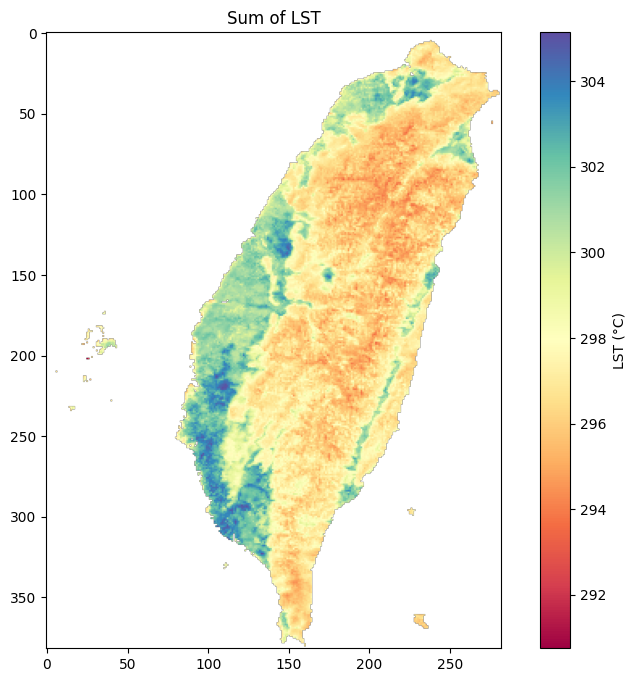

In [ ]:
# prompt: image show sum_lst

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
im = plt.imshow(sum_lst, cmap='Spectral') # Use imshow to create a mappable object
plt.title("Sum of LST")
plt.colorbar(im, label="LST (°C)")  # Pass the mappable object to colorbar
plt.show()

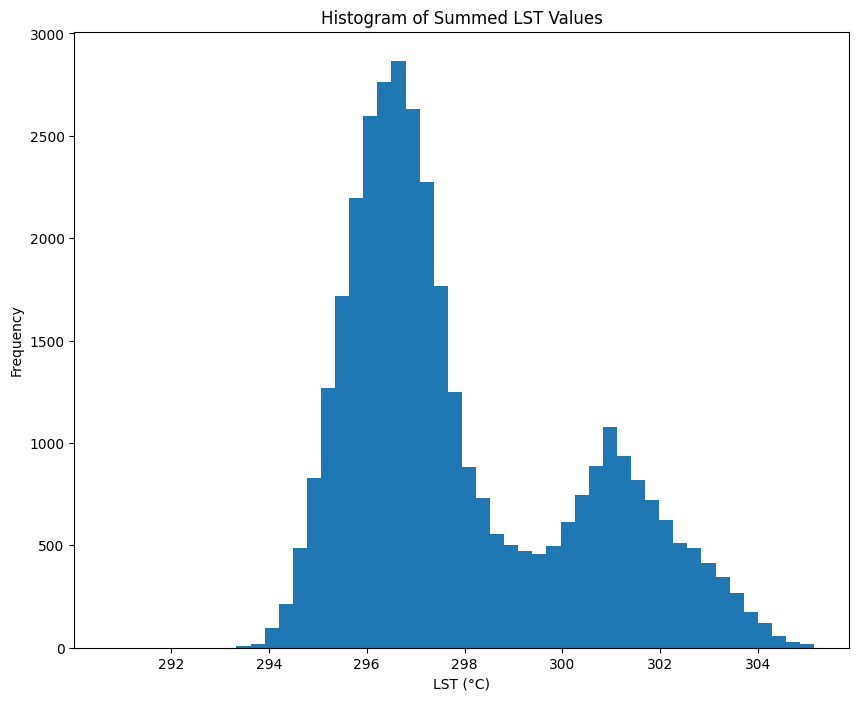

In [ ]:
# Assuming 'sum_lst' is already calculated as in your original code.

plt.figure(figsize=(10, 8))
plt.hist(sum_lst[np.isfinite(sum_lst)], bins=50)  # Exclude NaN values for the histogram
plt.xlabel("LST (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Summed LST Values")
plt.show()

# Plot_Tsc

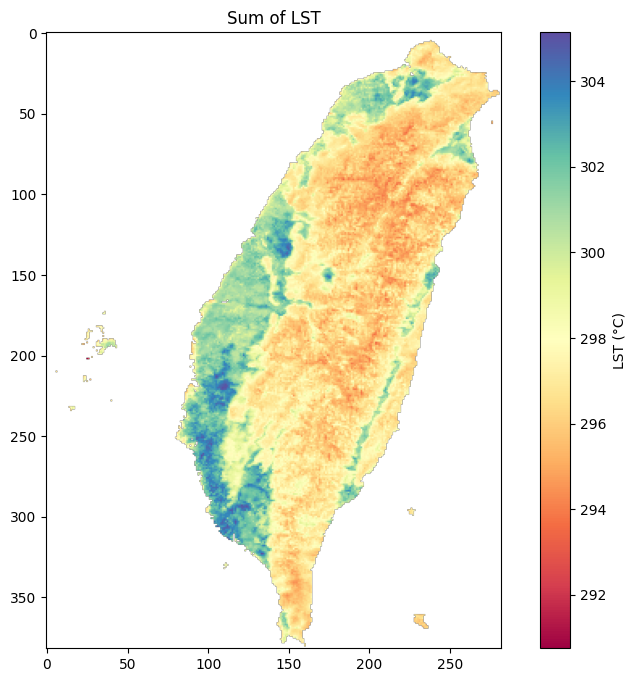

In [ ]:
# prompt: image show sum_lst

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
im = plt.imshow(sum_lst, cmap='Spectral') # Use imshow to create a mappable object
plt.title("Sum of LST")
plt.colorbar(im, label="LST (°C)")  # Pass the mappable object to colorbar
plt.show()


# Histogram of_Tsc

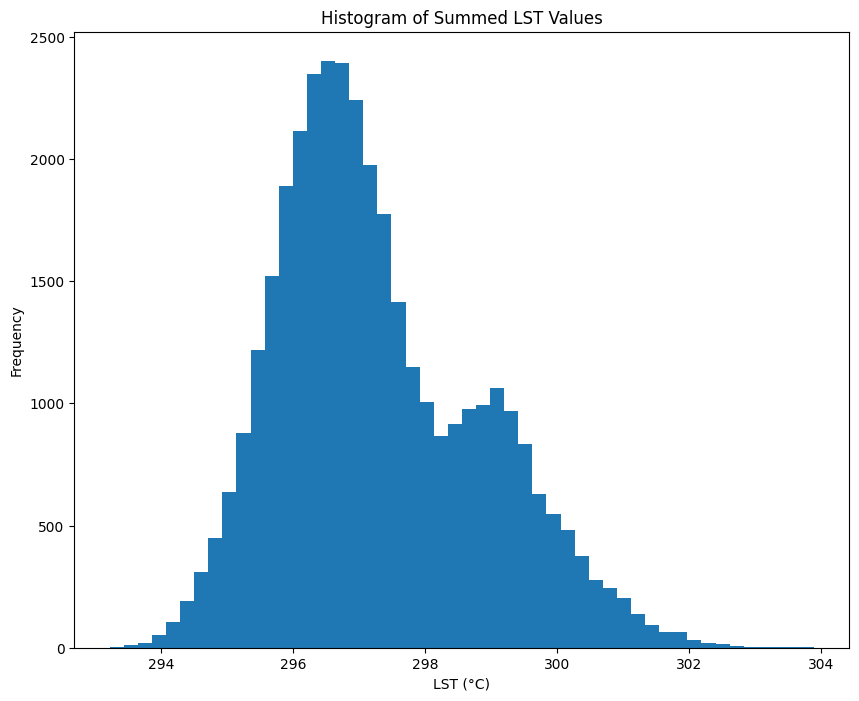

In [ ]:

# Assuming 'sum_lst' is already calculated as in your original code.

plt.figure(figsize=(10, 8))
plt.hist(sum_lst[np.isfinite(sum_lst)], bins=50)  # Exclude NaN values for the histogram
plt.xlabel("LST (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Summed LST Values")
plt.show()


# Save Tsc

In [ ]:
# Define the target folder for saving the output
Tsc_data_folder = '/content/drive/MyDrive/Taiwan_Yearly/Taiwan_2024'  # Ensure no extra spaces in the folder path

# Ensure the folder exists
os.makedirs(Tsc_data_folder, exist_ok=True)
# Define the output file path
sum_output_path = os.path.join(Tsc_data_folder, 'Sum_LST_2024.tif')

# Update metadata to handle float32 data and NaN values
original_meta.update(dtype=rasterio.float32, count=1, nodata=np.nan)

# Save the sum image as a GeoTIFF
with rasterio.open(sum_output_path, 'w', **original_meta) as dst:
    dst.write(sum_lst.astype(rasterio.float32), 1)

print("Sum LST image saved to:", sum_output_path)